# Prediciendo la diabetes
## El objetivo es predecir en base a medidas diagnósticas si un paciente tiene o no diabetes.

# 1.0 Importamos las librerias a utilizar

In [1]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, 
                              precision_score, recall_score, confusion_matrix, 
                              ConfusionMatrixDisplay)
from imblearn.metrics import specificity_score
import joblib
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import shap
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor


 # 1.1 Importamos los datos

In [3]:
df = pd.read_csv('/workspaces/carlos060495-intro-ml/data/raw/diabetes.csv')
pd.set_option('display.max_columns', None)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

# 2.1 Identificamos columnas con valores unicos

In [5]:
unicos = df.nunique()
df[unicos[unicos==1].index]

""
0
1
2
3
4
...
763
764
765
766


# 2.2 Eliminamos filas y columnas duplicadas

In [6]:
# Comprobar duplicados
df.duplicated().sum()

np.int64(0)

In [7]:
df.T.duplicated().sum()

np.int64(0)

# 2.3 Identificamos columnas redundantes

Tras realizar un análisis superficial del dataset, no se identificaron columnas redundantes evidentes. Cada una de las 9 columnas representa una medida diagnóstica diferente y cumple un propósito específico en la predicción de diabetes.

# 2.4 Eliminar columnas Data leakage

En este dataset no se identificaron columnas que generen data leakage. Todas las variables predictoras representan medidas diagnósticas que se pueden obtener antes de conocer el resultado del diagnóstico de diabetes.

# 2.5 Buscamos valores faltantes

In [8]:
df.shape

(768, 9)

In [9]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

Series([], dtype: float64)

# 2.5.1 Busqueda profunda de valores faltantes

In [10]:
# Buscar valores 0 en columnas específicas
columnas_a_revisar = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']

print("Análisis de valores 0 en columnas clave:")
print("="*60)

for columna in columnas_a_revisar:
    count_zeros = (df[columna] == 0).sum()
    porcentaje = (count_zeros / len(df)) * 100
    print(f"{columna:20s}: {count_zeros:4d} filas con 0 ({porcentaje:.2f}%)")

print("="*60)
print(f"Total de filas en el dataset: {len(df)}")

# Reemplazar valores 0 por NaN para su posterior tratamiento
print("\n" + "="*60)
print("Reemplazando valores 0 por NaN en columnas relevantes...")
print("="*60)

for columna in columnas_a_revisar:
    df[columna] = df[columna].replace(0, np.nan)
    
print("✅ Valores 0 reemplazados por NaN exitosamente")
print(f"\nNuevos valores faltantes por columna:")
faltantes_nuevos = df[columnas_a_revisar].isna().sum()
for columna, cantidad in faltantes_nuevos.items():
    porcentaje = (cantidad / len(df)) * 100
    print(f"{columna:20s}: {cantidad:4d} NaN ({porcentaje:.2f}%)")

Análisis de valores 0 en columnas clave:
Glucose             :    5 filas con 0 (0.65%)
BloodPressure       :   35 filas con 0 (4.56%)
SkinThickness       :  227 filas con 0 (29.56%)
Insulin             :  374 filas con 0 (48.70%)
BMI                 :   11 filas con 0 (1.43%)
Age                 :    0 filas con 0 (0.00%)
Total de filas en el dataset: 768

Reemplazando valores 0 por NaN en columnas relevantes...
✅ Valores 0 reemplazados por NaN exitosamente

Nuevos valores faltantes por columna:
Glucose             :    5 NaN (0.65%)
BloodPressure       :   35 NaN (4.56%)
SkinThickness       :  227 NaN (29.56%)
Insulin             :  374 NaN (48.70%)
BMI                 :   11 NaN (1.43%)
Age                 :    0 NaN (0.00%)


In [11]:
# Eliminar la columna Insulin (48.7% de valores faltantes) del dataframe original
print(f"📊 DataFrame antes: {df.shape}")
df.drop('Insulin', axis=1, inplace=True)

print(f"✅ Columna 'Insulin' eliminada")
print(f"📊 DataFrame después: {df.shape}")
print(f"\nColumnas restantes: {list(df.columns)}")
print(f"\nValores faltantes en el DataFrame:")
print(df.isna().sum())

📊 DataFrame antes: (768, 9)
✅ Columna 'Insulin' eliminada
📊 DataFrame después: (768, 8)

Columnas restantes: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Valores faltantes en el DataFrame:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


<Axes: >

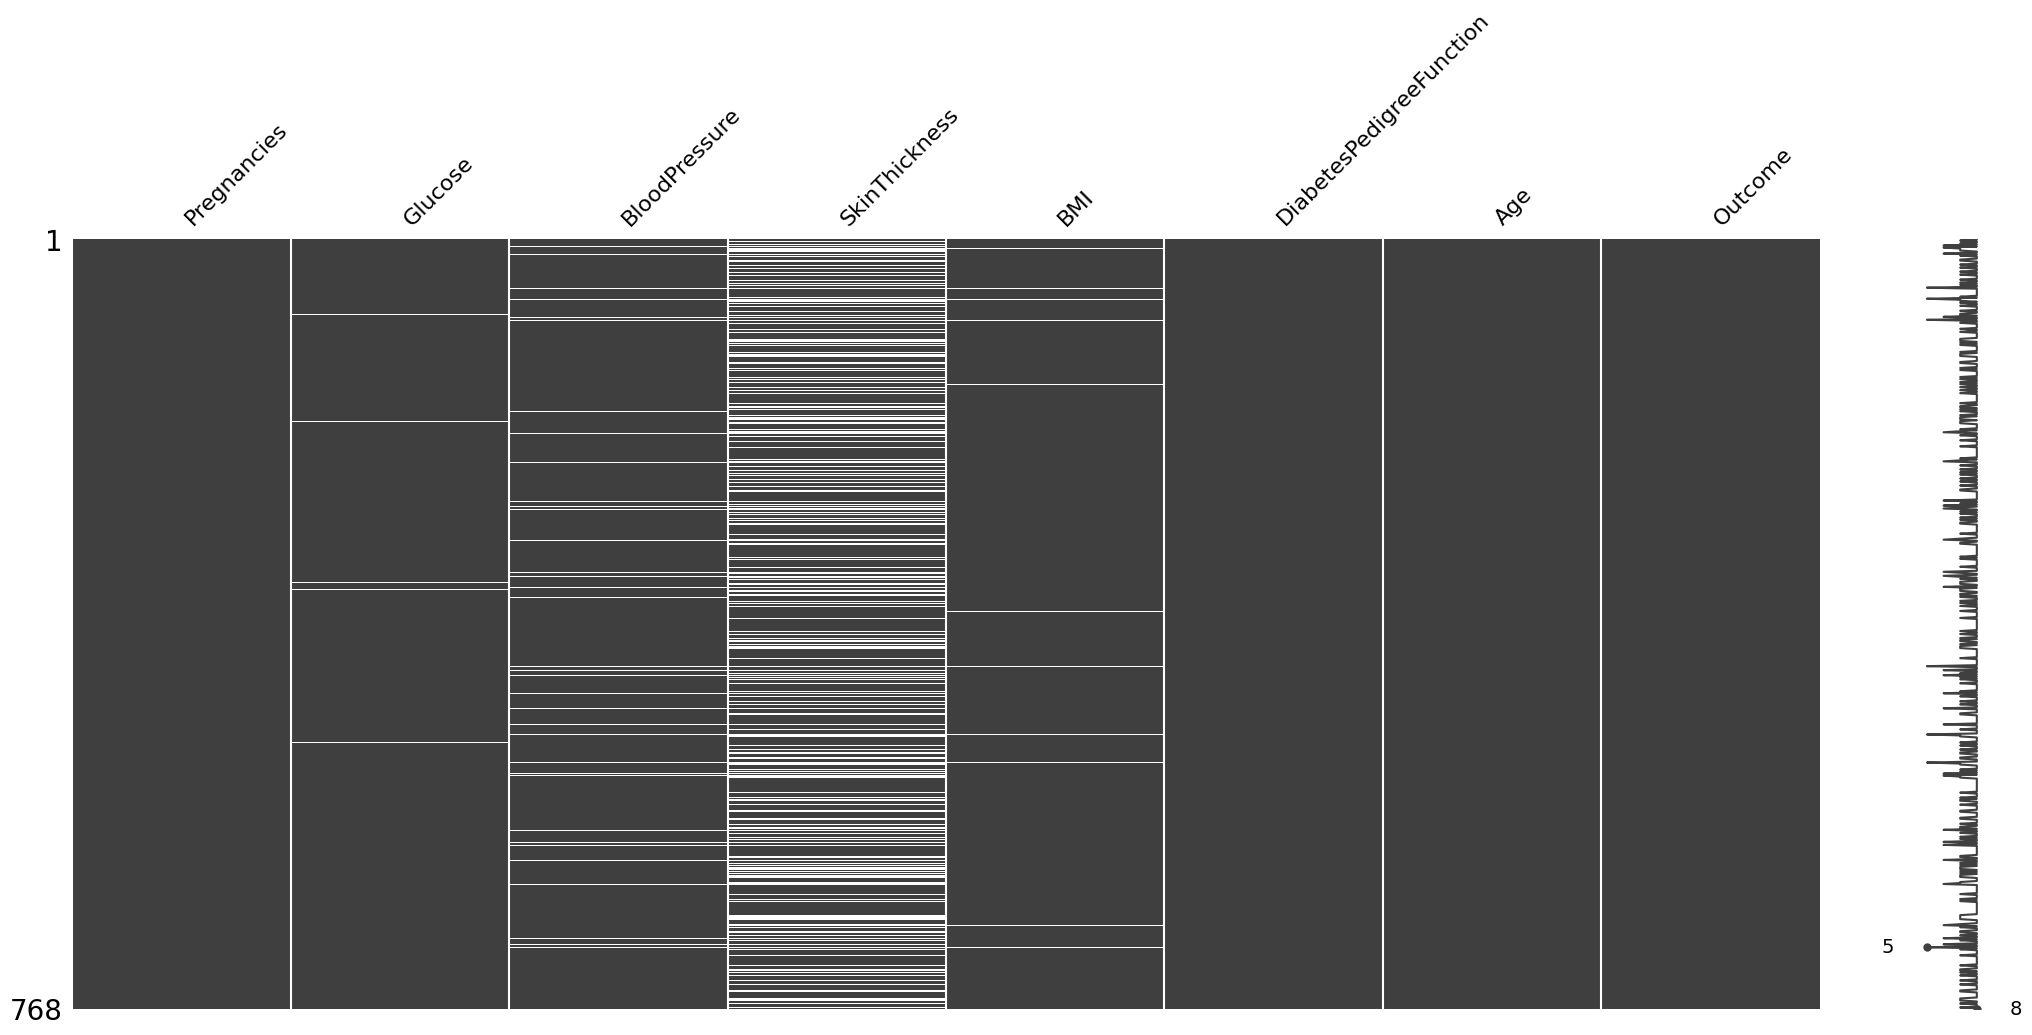

In [12]:
msno.matrix(df)

In [13]:
df.shape

(768, 8)

In [14]:
# Verificar si hay filas con valores faltantes
filas_con_faltantes = df.isnull().any(axis=1).sum()
print(f"Número de filas con valores faltantes: {filas_con_faltantes}")
print(f"Porcentaje de filas con valores faltantes: {filas_con_faltantes/len(df)*100:.2f}%")

Número de filas con valores faltantes: 236
Porcentaje de filas con valores faltantes: 30.73%


In [15]:
# Identificar filas con al menos 40% de valores faltantes
# Contar valores faltantes por fila (excluyendo 'Outcome')
df_sin_outcome = df.drop('Outcome', axis=1)
num_columnas = df_sin_outcome.shape[1]
umbral_40_porciento = num_columnas * 0.4

valores_faltantes_por_fila = df_sin_outcome.isnull().sum(axis=1)

# Filtrar filas con al menos 40% de valores faltantes
filas_40_faltantes = df[valores_faltantes_por_fila >= umbral_40_porciento]

print(f"Total de columnas (sin Outcome): {num_columnas}")
print(f"40% de {num_columnas} columnas = {umbral_40_porciento:.1f}")
print(f"Buscando filas con al menos {umbral_40_porciento:.1f} valores faltantes")
print(f"\nFilas con ≥40% de valores faltantes: {len(filas_40_faltantes)}")
print(f"Porcentaje del dataset: {len(filas_40_faltantes)/len(df)*100:.2f}%")

if len(filas_40_faltantes) > 0:
    print(f"\nDistribución de valores faltantes en estas filas:")
    print(valores_faltantes_por_fila[valores_faltantes_por_fila >= umbral_40_porciento].value_counts().sort_index())
    print(f"\nPrimeras {min(10, len(filas_40_faltantes))} filas con ≥40% de valores faltantes:")
    print(filas_40_faltantes.head(10))
else:
    print("\n✅ No hay filas con 40% o más de valores faltantes")

Total de columnas (sin Outcome): 7
40% de 7 columnas = 2.8
Buscando filas con al menos 2.8 valores faltantes

Filas con ≥40% de valores faltantes: 7
Porcentaje del dataset: 0.91%

Distribución de valores faltantes en estas filas:
3    7
Name: count, dtype: int64

Primeras 7 filas con ≥40% de valores faltantes:
     Pregnancies  Glucose  BloodPressure  SkinThickness  BMI  \
49             7    105.0            NaN            NaN  NaN   
60             2     84.0            NaN            NaN  NaN   
81             2     74.0            NaN            NaN  NaN   
426            0     94.0            NaN            NaN  NaN   
494            3     80.0            NaN            NaN  NaN   
522            6    114.0            NaN            NaN  NaN   
706           10    115.0            NaN            NaN  NaN   

     DiabetesPedigreeFunction  Age  Outcome  
49                      0.305   24        0  
60                      0.304   21        0  
81                      0.102   22   

In [16]:
# Eliminar filas con 40% o más de valores faltantes
print(f"📊 DataFrame antes de eliminar: {df.shape}")

# Identificar índices de filas a eliminar
indices_a_eliminar = filas_40_faltantes.index

# Eliminar las filas
df.drop(indices_a_eliminar, inplace=True)

print(f"✅ Eliminadas {len(indices_a_eliminar)} filas con ≥40% de valores faltantes")
print(f"📊 DataFrame después de eliminar: {df.shape}")
print(f"\nValores faltantes restantes por columna:")
print(df.isna().sum())

📊 DataFrame antes de eliminar: (768, 8)
✅ Eliminadas 7 filas con ≥40% de valores faltantes
📊 DataFrame después de eliminar: (761, 8)

Valores faltantes restantes por columna:
Pregnancies                   0
Glucose                       5
BloodPressure                28
SkinThickness               220
BMI                           4
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


# 2.6 Identificación de valores faltantes

In [17]:
# Verificar los valores faltantes antes del split
print("Valores faltantes por columna:")
print(df.isna().sum())
print(f"\nTotal de valores faltantes: {df.isna().sum().sum()}")
print(f"📊 Forma del dataframe: {df.shape}")

Valores faltantes por columna:
Pregnancies                   0
Glucose                       5
BloodPressure                28
SkinThickness               220
BMI                           4
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Total de valores faltantes: 257
📊 Forma del dataframe: (761, 8)


# 2.7 Guardar dataframe limpio para reutilización

Se guarda el dataframe con los valores 0 reemplazados por NaN (pero sin imputar) para que otros ejercicios puedan aplicar sus propias estrategias de imputación sin data leakage.

In [18]:
# Guardar el dataframe limpio (con NaN, sin imputar) para uso en otros ejercicios
os.makedirs('/workspaces/carlos060495-intro-ml/data/processed', exist_ok=True)
df.to_pickle('/workspaces/carlos060495-intro-ml/data/processed/diabetes_clean.pkl')

print("✅ Dataframe guardado exitosamente en:")
print("   📁 data/processed/diabetes_clean.pkl")
print(f"\n📊 Forma del dataframe: {df.shape}")
print(f"📋 Columnas: {list(df.columns)}")
print(f"⚠️  Valores faltantes: {df.isna().sum().sum()} (listos para imputar según necesidad)")

✅ Dataframe guardado exitosamente en:
   📁 data/processed/diabetes_clean.pkl

📊 Forma del dataframe: (761, 8)
📋 Columnas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
⚠️  Valores faltantes: 257 (listos para imputar según necesidad)


# 2.8 Análisis exploratorio de outliers

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,761.0,3.840999,3.370491,0.000,1.000,3.000,6.000,17.00
Glucose,756.0,121.932540,30.533481,44.000,100.000,117.000,141.000,199.00
BloodPressure,733.0,72.405184,12.382158,24.000,64.000,72.000,80.000,122.00
SkinThickness,541.0,29.153420,10.476982,7.000,22.000,29.000,36.000,99.00
BMI,757.0,32.457464,6.924988,18.200,27.500,32.300,36.600,67.10
DiabetesPedigreeFunction,761.0,0.474126,0.331947,0.078,0.244,0.378,0.629,2.42
Age,761.0,33.323259,11.779469,21.000,24.000,29.000,41.000,81.00
Outcome,761.0,0.350854,0.477551,0.000,0.000,0.000,1.000,1.00


## Decisión sobre outliers

Tras analizar las estadísticas descriptivas, se identificaron valores atípicos en varias variables (SkinThickness máx=99mm, BMI máx=67.1, DiabetesPedigreeFunction máx=2.42). Sin embargo, se ha decidido **NO aplicar tratamiento de outliers** debido a que: (1) los árboles de decisión son naturalmente robustos a valores extremos, (2) estos outliers pueden representar casos reales de pacientes de alto riesgo que son clínicamente relevantes para predecir diabetes, (3) el dataset es relativamente pequeño (761 filas) y no conviene eliminar más observaciones, y (4) los valores extremos pueden ser predictores importantes del outcome. El modelo trabajará con todos los datos disponibles después de la imputación.

# 3.1 Train test split

In [20]:
X = df.drop('Outcome',axis=1)
y = df['Outcome']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3.2 Imputamos los valores faltantes

In [22]:
# Crear el imputador iterativo
imputer = IterativeImputer(random_state=42, max_iter=10, verbose=0)

print("Valores faltantes ANTES de la imputación:")
print(f"X_train: {X_train.isna().sum().sum()} valores faltantes")
print(f"X_test: {X_test.isna().sum().sum()} valores faltantes")

# PASO 1: Entrenar el imputador SOLO con los datos de entrenamiento
imputer.fit(X_train)

# PASO 2: Transformar ambos conjuntos usando el imputador entrenado
X_train_imputed = pd.DataFrame(
    imputer.transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("\n" + "="*60)
print("Valores faltantes DESPUÉS de la imputación:")
print(f"X_train: {X_train_imputed.isna().sum().sum()} valores faltantes")
print(f"X_test: {X_test_imputed.isna().sum().sum()} valores faltantes")

# Verificar valores negativos y corregirlos si existen
for col in X_train_imputed.columns:
    if (X_train_imputed[col] < 0).any():
        print(f"⚠️  Corrigiendo valores negativos en {col}")
        median_val = X_train_imputed[X_train_imputed[col] >= 0][col].median()
        X_train_imputed.loc[X_train_imputed[col] < 0, col] = median_val
        X_test_imputed.loc[X_test_imputed[col] < 0, col] = median_val

print("\n✅ Imputación completada correctamente SIN data leakage")
print(f"📊 X_train shape: {X_train_imputed.shape}")
print(f"📊 X_test shape: {X_test_imputed.shape}")

# Actualizar los conjuntos de datos
X_train = X_train_imputed
X_test = X_test_imputed

Valores faltantes ANTES de la imputación:
X_train: 192 valores faltantes
X_test: 65 valores faltantes

Valores faltantes DESPUÉS de la imputación:
X_train: 0 valores faltantes
X_test: 0 valores faltantes

✅ Imputación completada correctamente SIN data leakage
📊 X_train shape: (608, 7)
📊 X_test shape: (153, 7)


# 3.3  Seleccion de caracteristicas

## Método 1: Feature importance de RF

In [23]:
# Entrenamiento de RF
model = RandomForestClassifier(random_state=42,n_jobs=-1).fit(X_train, y_train)

In [24]:
# Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100

# Convertir a DataFrame
df_rf_imp = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

# Calculamos la importancia acumulada
df_rf_imp['rf_importance_acum'] = df_rf_imp['rf_importance'].cumsum()
df_rf_imp

,feature,rf_importance,rf_importance_acum
1,Glucose,25.672453,25.672453
4,BMI,15.971354,41.643807
6,Age,14.348388,55.992195
3,SkinThickness,13.339343,69.331538
5,DiabetesPedigreeFunction,13.126081,82.457619
2,BloodPressure,9.051060,91.508679
0,Pregnancies,8.491321,100.000000


## Método 2: Permutation/Shuffle importance

In [25]:
# Para esta técnica y la de shap se necesita conjunto de validación
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ajustamos el modelo
model_xgb = XGBClassifier(random_state=42).fit(X_train1, y_train1)

In [26]:
# Realizamos 10 permutaciones por cada característica
# Usamos 'accuracy' como scoring para clasificación (más interpretable)
perm = permutation_importance(model_xgb, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1, scoring='accuracy')

In [27]:
# Crear DataFrame con importancias en porcentaje
df_perm_imp = pd.DataFrame({
    'feature': X_train.columns, 
    'perm_imp': perm.importances_mean * 100
}).sort_values('perm_imp', ascending=False)

# Redondear para mejor visualización
df_perm_imp['perm_imp'] = df_perm_imp['perm_imp'].round(2)
df_perm_imp

,feature,perm_imp
1,Glucose,11.72
6,Age,7.38
4,BMI,6.39
5,DiabetesPedigreeFunction,3.52
0,Pregnancies,0.98
3,SkinThickness,0.74
2,BloodPressure,-1.64


## Método 3: SHAP

In [28]:
# Ajustamos el modelo
model_lgbm = lgb.LGBMClassifier(random_state=42, n_jobs=-1).fit(X_train1, y_train1)

# Crear explainer y calcular valores SHAP (desactivando check_additivity por pequeñas diferencias numéricas)
explainer = shap.Explainer(model_lgbm, X_val)
shap_vals = explainer(X_val, check_additivity=False).values

[LightGBM] [Info] Number of positive: 165, number of negative: 321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 486, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339506 -> initscore=-0.665496
[LightGBM] [Info] Start training from score -0.665496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [29]:
imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap/imp_shap.sum()*100
df_shap_imp = pd.DataFrame({"feature": X_val.columns, "shap_imp": imp_shap_pct}).sort_values('shap_imp', ascending=False)
df_shap_imp

,feature,shap_imp
1,Glucose,28.159462
6,Age,21.034861
4,BMI,14.755008
3,SkinThickness,12.014322
5,DiabetesPedigreeFunction,10.300338
2,BloodPressure,8.845431
0,Pregnancies,4.890579


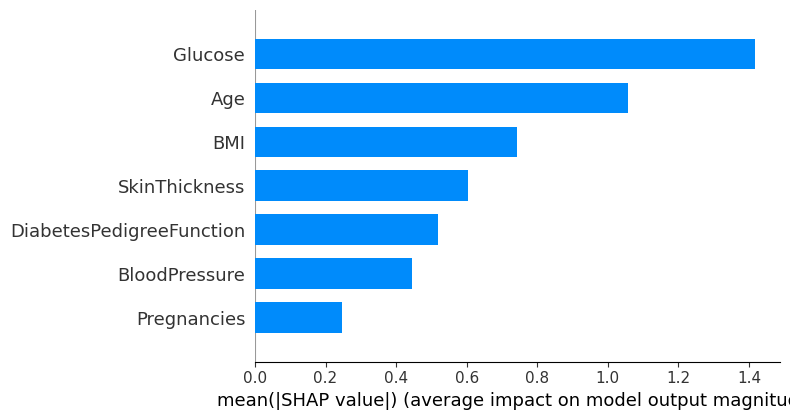

In [30]:
# --- SHAP Summary Bar Plot ---
shap.summary_plot(shap_vals, X_val, plot_type="bar")

## Unión 3 métodos

In [31]:
df_importances = (
    df_rf_imp
    .merge(df_perm_imp, on='feature', how='outer')
    .merge(df_shap_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
4,Glucose,25.672453,25.672453,11.72,28.159462
1,BMI,15.971354,41.643807,6.39,14.755008
0,Age,14.348388,55.992195,7.38,21.034861
6,SkinThickness,13.339343,69.331538,0.74,12.014322
3,DiabetesPedigreeFunction,13.126081,82.457619,3.52,10.300338
2,BloodPressure,9.051060,91.508679,-1.64,8.845431
5,Pregnancies,8.491321,100.000000,0.98,4.890579


In [32]:
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp']>=1)&(df_importances['shap_imp']>=1)]
df_filt

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
4,Glucose,25.672453,25.672453,11.72,28.159462
1,BMI,15.971354,41.643807,6.39,14.755008
0,Age,14.348388,55.992195,7.38,21.034861
3,DiabetesPedigreeFunction,13.126081,82.457619,3.52,10.300338


In [33]:
features = df_filt['feature']
features

4                     Glucose
1                         BMI
0                         Age
3    DiabetesPedigreeFunction
Name: feature, dtype: object

In [34]:
X_vif = add_constant(X_train[features])

vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)
vif = vif.drop("const")
vif

Glucose                     1.151266
BMI                         1.070675
Age                         1.091318
DiabetesPedigreeFunction    1.044182
dtype: float64

# 4.1 Arbol de desicion simple

In [35]:
# Entrenar modelos con las características seleccionadas
simple_tree = DecisionTreeClassifier(max_depth=3, max_features=len(features)//2, min_samples_leaf=20, random_state=42)
simple_tree.fit(X_train[features], y_train)

complex_tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1, random_state=42)
complex_tree.fit(X_train[features], y_train)

# Evaluar el modelo complejo en entrenamiento y prueba
train_pred_complex = complex_tree.predict(X_train[features])
test_pred_complex = complex_tree.predict(X_test[features])

# Evaluar el modelo simple en entrenamiento y prueba
train_pred_simple = simple_tree.predict(X_train[features])
test_pred_simple = simple_tree.predict(X_test[features])

In [36]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [37]:
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.776316,0.617978,0.716364,0.785714,0.509259,0.923469
Test,0.784314,0.629213,0.725490,0.736842,0.549020,0.901961
Diferencia,-0.007998,-0.011236,-0.009126,0.048872,-0.039760,0.021509


In [38]:
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Test,0.784314,0.707965,0.784314,0.645161,0.784314,0.784314
Diferencia,0.215686,0.292035,0.215686,0.354839,0.215686,0.215686


In [39]:
# Matriz de confusión
cm = confusion_matrix(y_test, test_pred_simple)
cm

array([[92, 10],
       [23, 28]])

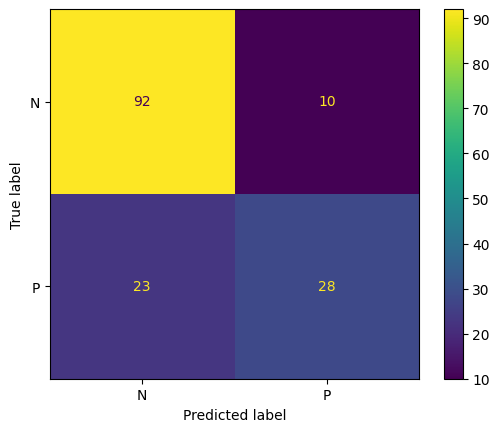

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'P'])
disp.plot()

In [41]:
text_representation = export_text(simple_tree, feature_names=list(features))
print(text_representation)

|--- Glucose <= 127.50
|   |--- BMI <= 27.00
|   |   |--- DiabetesPedigreeFunction <= 0.30
|   |   |   |--- class: 0
|   |   |--- DiabetesPedigreeFunction >  0.30
|   |   |   |--- class: 0
|   |--- BMI >  27.00
|   |   |--- Glucose <= 99.50
|   |   |   |--- class: 0
|   |   |--- Glucose >  99.50
|   |   |   |--- class: 0
|--- Glucose >  127.50
|   |--- DiabetesPedigreeFunction <= 0.32
|   |   |--- Glucose <= 162.50
|   |   |   |--- class: 0
|   |   |--- Glucose >  162.50
|   |   |   |--- class: 1
|   |--- DiabetesPedigreeFunction >  0.32
|   |   |--- BMI <= 28.80
|   |   |   |--- class: 0
|   |   |--- BMI >  28.80
|   |   |   |--- class: 1



# 4.2 Comparación de criterios de pureza

In [42]:
# Definir los criterios a probar
criterios = ['gini', 'entropy', 'log_loss']

# Diccionario para almacenar los modelos y resultados
resultados = {}

# Entrenar un modelo con cada criterio usando las características seleccionadas
for criterio in criterios:
    # Crear el modelo
    modelo = DecisionTreeClassifier(
        criterion=criterio,
        max_depth=5,
        min_samples_leaf=15,
        random_state=42
    )
    
    # Entrenar con características seleccionadas
    modelo.fit(X_train[features], y_train)
    
    # Predicciones
    y_pred_train = modelo.predict(X_train[features])
    y_pred_test = modelo.predict(X_test[features])
    
    # Guardar resultados
    resultados[criterio] = {
        'modelo': modelo,
        'train_pred': y_pred_train,
        'test_pred': y_pred_test,
        'metrics': get_metrics(y_train, y_test, y_pred_train, y_pred_test)
    }
    
print("Modelos entrenados exitosamente para todos los criterios con características seleccionadas.")

Modelos entrenados exitosamente para todos los criterios con características seleccionadas.


In [43]:
# Mostrar las métricas de cada criterio
for criterio in criterios:
    print(f"\n{'='*60}")
    print(f"CRITERIO: {criterio.upper()}")
    print(f"{'='*60}")
    print(resultados[criterio]['metrics'])


CRITERIO: GINI
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.800987  0.668493  0.747969   0.818792  0.564815     0.931122
Test        0.764706  0.600000  0.705882   0.692308  0.529412     0.882353
Diferencia  0.036281  0.068493  0.042086   0.126484  0.035403     0.048770

CRITERIO: ENTROPY
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.804276  0.694087  0.764031   0.780347  0.625000     0.903061
Test        0.797386  0.693069  0.769608   0.700000  0.686275     0.852941
Diferencia  0.006891  0.001018 -0.005577   0.080347 -0.061275     0.050120

CRITERIO: LOG_LOSS
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.804276  0.694087  0.764031   0.780347  0.625000     0.903061
Test        0.797386  0.693069  0.769608   0.700000  0.686275     0.852941
Diferencia  0.006891  0.001018 -0.005577   0.080347 -0.061275     0.050120


In [44]:
# Crear DataFrame comparativo con métricas de test
comparacion_test = pd.DataFrame({
    'Gini': resultados['gini']['metrics'].loc['Test'],
    'Entropy': resultados['entropy']['metrics'].loc['Test'],
    'Log_Loss': resultados['log_loss']['metrics'].loc['Test']
}).T

print("Comparación de métricas en conjunto de TEST:")
print(comparacion_test)

Comparación de métricas en conjunto de TEST:
          Accuracy        F1       AUC  Precision    Recall  Specificity
Gini      0.764706  0.600000  0.705882   0.692308  0.529412     0.882353
Entropy   0.797386  0.693069  0.769608   0.700000  0.686275     0.852941
Log_Loss  0.797386  0.693069  0.769608   0.700000  0.686275     0.852941


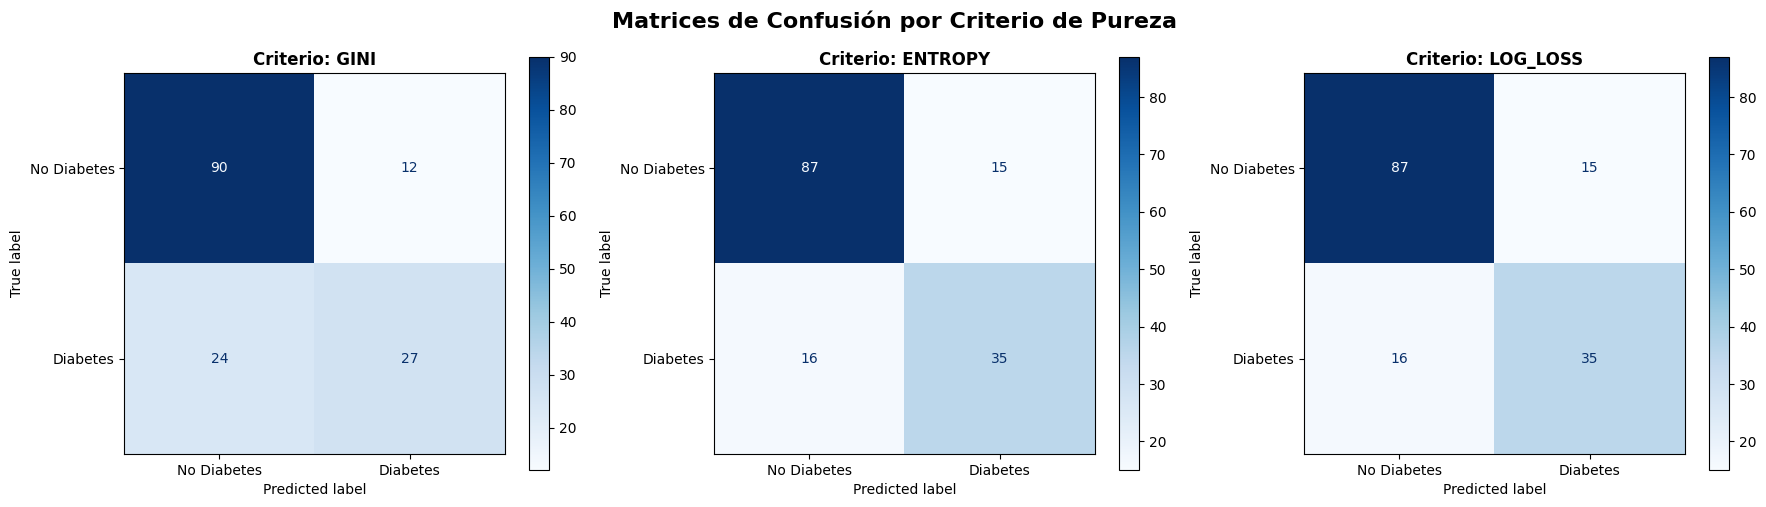

In [45]:
# Comparar matrices de confusión de los tres criterios
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Matrices de Confusión por Criterio de Pureza', fontsize=16, fontweight='bold')

for idx, criterio in enumerate(criterios):
    cm = confusion_matrix(y_test, resultados[criterio]['test_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'Criterio: {criterio.upper()}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Selección del mejor criterio
Después de analizar los resultados de los tres criterios de pureza, observamos que **Entropy y Log_Loss produjeron métricas idénticas** y superiores a Gini


# 5.1 Hiperparametros

In [46]:
# Definir el espacio de hiperparámetros para DecisionTreeClassifier
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 15, 20, 25],
    'max_features': [None, 'sqrt', 'log2']
}

# Entrenar con ambos criterios seleccionados: entropy y log_loss
criterios_seleccionados = ['entropy', 'log_loss']
best_models = {}

for criterio in criterios_seleccionados:
    print(f"\n{'='*60}")
    print(f"Búsqueda de hiperparámetros con criterion='{criterio}'")
    print(f"{'='*60}")
    
    # Crear el modelo base con el criterio actual
    dt_model = DecisionTreeClassifier(criterion=criterio, random_state=42)
    
    # GridSearchCV con validación cruzada
    grid_search = GridSearchCV(
        estimator=dt_model,
        param_grid=param_grid,
        scoring='f1',  # Usamos F1 por el balance entre precision y recall
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    
    # Ajustar el modelo
    grid_search.fit(X_train[features], y_train)
    
    # Mostrar mejores hiperparámetros
    print(f"\nMejores hiperparámetros para {criterio}:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"\nMejor F1 Score en validación cruzada: {grid_search.best_score_:.4f}")
    
    # Guardar el mejor modelo
    best_models[criterio] = grid_search.best_estimator_

print("\n" + "="*60)
print("✅ Optimización completada para ambos criterios")
print("="*60)


Búsqueda de hiperparámetros con criterion='entropy'
Fitting 5 folds for each of 300 candidates, totalling 1500 fits

Mejores hiperparámetros para entropy:
  max_depth: 7
  max_features: None
  min_samples_leaf: 10
  min_samples_split: 2

Mejor F1 Score en validación cruzada: 0.6313

Búsqueda de hiperparámetros con criterion='log_loss'
Fitting 5 folds for each of 300 candidates, totalling 1500 fits

Mejores hiperparámetros para log_loss:
  max_depth: 7
  max_features: None
  min_samples_leaf: 10
  min_samples_split: 2

Mejor F1 Score en validación cruzada: 0.6313

✅ Optimización completada para ambos criterios


In [47]:
# Evaluar ambos modelos optimizados
print("="*60)
print("COMPARACIÓN DE MODELOS OPTIMIZADOS")
print("="*60)

for criterio in criterios_seleccionados:
    print(f"\n{'='*60}")
    print(f"CRITERIO: {criterio.upper()}")
    print(f"{'='*60}")
    
    model = best_models[criterio]
    
    # Predicciones
    y_pred_train = model.predict(X_train[features])
    y_pred_test = model.predict(X_test[features])
    
    # Obtener métricas
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
    print(metrics)

COMPARACIÓN DE MODELOS OPTIMIZADOS

CRITERIO: ENTROPY
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.824013  0.745843  0.802201   0.765854  0.726852     0.877551
Test        0.751634  0.634615  0.725490   0.622642  0.647059     0.803922
Diferencia  0.072379  0.111228  0.076711   0.143212  0.079793     0.073629

CRITERIO: LOG_LOSS
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.824013  0.745843  0.802201   0.765854  0.726852     0.877551
Test        0.751634  0.634615  0.725490   0.622642  0.647059     0.803922
Diferencia  0.072379  0.111228  0.076711   0.143212  0.079793     0.073629


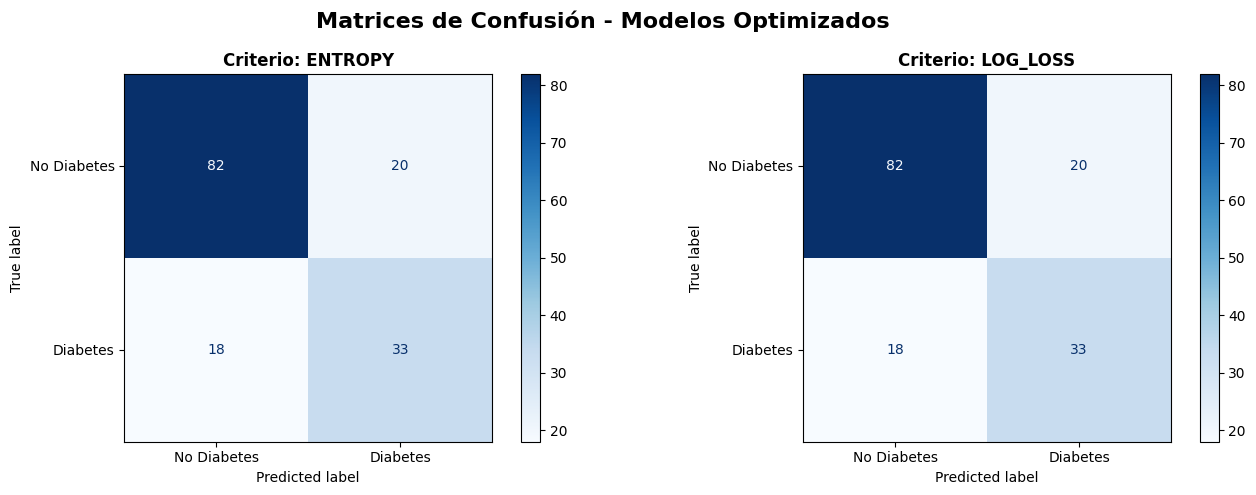

In [48]:
# Comparar matrices de confusión de los modelos optimizados
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Matrices de Confusión - Modelos Optimizados', fontsize=16, fontweight='bold')

for idx, criterio in enumerate(criterios_seleccionados):
    y_pred_test = best_models[criterio].predict(X_test[features])
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'Criterio: {criterio.upper()}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [49]:
# Comparación completa de todos los modelos entrenados
print("="*80)
print("COMPARACIÓN COMPLETA DE TODOS LOS MODELOS")
print("="*80)

# Diccionario para almacenar todas las métricas
comparacion_completa = {}

# 1. Simple Tree
y_pred_test_simple = simple_tree.predict(X_test[features])
metrics_simple = get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)
comparacion_completa['Simple Tree'] = metrics_simple.loc['Test']

# 2. Complex Tree
y_pred_test_complex = complex_tree.predict(X_test[features])
metrics_complex = get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)
comparacion_completa['Complex Tree'] = metrics_complex.loc['Test']

# 3. Entropy (sin optimizar)
y_pred_test_entropy = resultados['entropy']['modelo'].predict(X_test[features])
y_pred_train_entropy = resultados['entropy']['modelo'].predict(X_train[features])
metrics_entropy = get_metrics(y_train, y_test, y_pred_train_entropy, y_pred_test_entropy)
comparacion_completa['Entropy (no opt)'] = metrics_entropy.loc['Test']

# 4. Log_loss (sin optimizar)
y_pred_test_logloss = resultados['log_loss']['modelo'].predict(X_test[features])
y_pred_train_logloss = resultados['log_loss']['modelo'].predict(X_train[features])
metrics_logloss = get_metrics(y_train, y_test, y_pred_train_logloss, y_pred_test_logloss)
comparacion_completa['Log_Loss (no opt)'] = metrics_logloss.loc['Test']

# 5. Entropy (optimizado)
y_pred_test_entropy_opt = best_models['entropy'].predict(X_test[features])
y_pred_train_entropy_opt = best_models['entropy'].predict(X_train[features])
metrics_entropy_opt = get_metrics(y_train, y_test, y_pred_train_entropy_opt, y_pred_test_entropy_opt)
comparacion_completa['Entropy (optimizado)'] = metrics_entropy_opt.loc['Test']

# 6. Log_loss (optimizado)
y_pred_test_logloss_opt = best_models['log_loss'].predict(X_test[features])
y_pred_train_logloss_opt = best_models['log_loss'].predict(X_train[features])
metrics_logloss_opt = get_metrics(y_train, y_test, y_pred_train_logloss_opt, y_pred_test_logloss_opt)
comparacion_completa['Log_Loss (optimizado)'] = metrics_logloss_opt.loc['Test']

# Crear DataFrame comparativo
df_comparacion = pd.DataFrame(comparacion_completa).T

print("\n📊 MÉTRICAS DE TEST PARA TODOS LOS MODELOS:")
print("="*80)
print(df_comparacion.round(4))

# Identificar el mejor modelo por cada métrica
print("\n" + "="*80)
print("🏆 MEJORES MODELOS POR MÉTRICA:")
print("="*80)
for metrica in df_comparacion.columns:
    mejor_modelo = df_comparacion[metrica].idxmax()
    mejor_valor = df_comparacion[metrica].max()
    print(f"{metrica:15s}: {mejor_modelo:25s} ({mejor_valor:.4f})")

COMPARACIÓN COMPLETA DE TODOS LOS MODELOS

📊 MÉTRICAS DE TEST PARA TODOS LOS MODELOS:
                       Accuracy      F1     AUC  Precision  Recall  \
Simple Tree              0.7843  0.6292  0.7255     0.7368  0.5490   
Complex Tree             0.7843  0.7080  0.7843     0.6452  0.7843   
Entropy (no opt)         0.7974  0.6931  0.7696     0.7000  0.6863   
Log_Loss (no opt)        0.7974  0.6931  0.7696     0.7000  0.6863   
Entropy (optimizado)     0.7516  0.6346  0.7255     0.6226  0.6471   
Log_Loss (optimizado)    0.7516  0.6346  0.7255     0.6226  0.6471   

                       Specificity  
Simple Tree                 0.9020  
Complex Tree                0.7843  
Entropy (no opt)            0.8529  
Log_Loss (no opt)           0.8529  
Entropy (optimizado)        0.8039  
Log_Loss (optimizado)       0.8039  

🏆 MEJORES MODELOS POR MÉTRICA:
Accuracy       : Entropy (no opt)          (0.7974)
F1             : Complex Tree              (0.7080)
AUC            : Complex Tre

## Conclusión: Complex Tree como mejor modelo

El **Complex Tree** destaca como el mejor modelo al obtener el **F1 Score más alto (0.7080)** y el **mejor AUC (0.7843)**, métricas clave que reflejan un balance óptimo entre precisión y exhaustividad. Además, su **Recall de 0.7843** es fundamental en el contexto médico, ya que maximiza la detección de casos positivos de diabetes, reduciendo así los falsos negativos que podrían dejar sin diagnóstico a pacientes enfermos. Aunque tiene menor especificidad que el Simple Tree, su capacidad para identificar correctamente a los pacientes diabéticos lo posiciona como la opción más adecuada para este problema clínico.

In [50]:
# Guardar el mejor modelo (Complex Tree)
model_path = '/workspaces/carlos060495-intro-ml/models/decision_tree_diabetes_complex.pkl'
joblib.dump(complex_tree, model_path)

print(f"✅ Modelo 'Complex Tree' guardado en: {model_path}")

✅ Modelo 'Complex Tree' guardado en: /workspaces/carlos060495-intro-ml/models/decision_tree_diabetes_complex.pkl
